Til at evaluere recall per snr. Simuler kun én psf per billede.

For box in predboxes
    If box and targetbox iou > .5
        Add targetsnr and TP += 1
        break
add targetsnr and FN +=1

In [1]:
from PsfSimulator import PsfSimulator, PsfDataset
from scripts.plotting import PlotController
import PIL
from PIL import Image
import torchvision.transforms as T


sim = PsfSimulator(snr_mean=3, base_noise=100, img_h=15, img_w=15, sigma_mean=1.5)
image, target = sim.generate(num_spots=1)
image = image*10000
# Tensor to numpy array
image = image.numpy().astype('uint16')
print(image.max())
print(image.mean())

# Plot the numpy array using matplotlib
image = image[0]

import matplotlib.pyplot as plt


135
100.82222222222222


In [2]:

import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
imagecopy = image.copy()
imagecopy = imagecopy.astype(np.float32)
print(image.max())
imagecopy[6:9,6:9] = np.nan
print(np.nanmean(imagecopy))
print(np.nanstd(imagecopy))

135
100.74074
10.251802


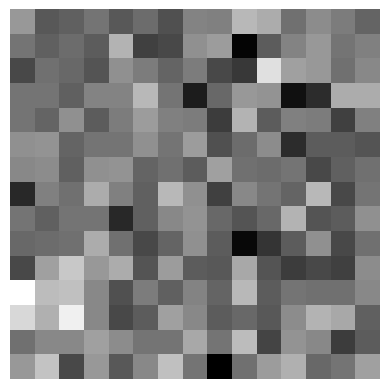

In [4]:
plt.imshow(image, cmap='gray')
plt.axis('off')
%matplotlib inline
plt.show()

In [59]:
# image is your 2D numpy array
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the shape
ny, nx = image.shape

# Create X, Y positions for each bar
_x = np.arange(nx)
_y = np.arange(ny)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
z = np.zeros_like(x)

# The bar heights are the pixel values
dz = image.ravel()
z_min = 70

# Width and depth of each bar
dx = dy = 1 * np.ones_like(z)

normed = (dz - dz.min()) / (dz.max() - dz.min())
colors = cm.jet(normed)

ax.bar3d(x, y, z+z_min, dx, dy, dz-z_min, shade=True, color=colors, zsort='min')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Pixel Value')
ax.set_zlim(z_min, z_min+70)
%matplotlib qt
plt.show()



/var/folders/sr/ychn_0nn4b54j0qp8gmljtr80000gn/T/ipykernel_48953/4179902590.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# image is your 2D numpy array
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create X and Y coordinate arrays
X = np.arange(image.shape[1])
Y = np.arange(image.shape[0])
X, Y = np.meshgrid(X, Y)

# The bar heights are the pixel values
dz = image.ravel()
z_min = 70

# Width and depth of each bar
dx = dy = 1 * np.ones_like(z)

# Plot the surface
ax.plot_surface(X, Y, image, cmap='gnuplot')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Pixel Value')
plt.show()

/var/folders/sr/ychn_0nn4b54j0qp8gmljtr80000gn/T/ipykernel_48953/53948189.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


2025-05-24 17:17:23.749 python[48953:17631804] The class 'NSSavePanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
2025-05-24 17:19:05.855 python[48953:17631804] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-24 17:19:05.855 python[48953:17631804] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-24 17:19:05.855 python[48953:17631804] Text input context does not respond to _valueForTIProperty:


# SNR TROUBLESHOOTING

In [7]:
def make_psf(sigma, intensity, subpos):
    radius = int(np.ceil(3 * sigma))
    array = np.zeros((radius * 2 + 1, radius * 2 + 1))
    yy, xx = np.ogrid[-radius:radius + 1, -radius:radius + 1]
    subpos = (subpos[0] - 0.5, subpos[1] - 0.5)
    r2 = (xx - subpos[0]) ** 2 + (yy - subpos[1]) ** 2
    signals = np.exp(-r2 / (2 * sigma ** 2)) 
    array = signals * intensity
    return array.astype(np.float32)

100.0


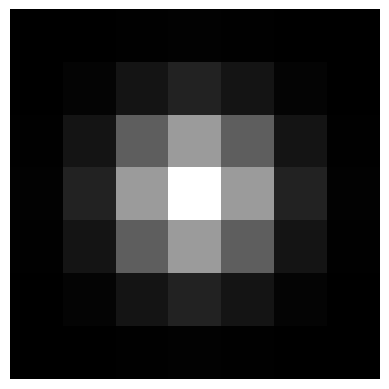

In [39]:
psf_1s_100int = make_psf(1, 100, (0.5,0.5)).astype(np.float32)
print(np.max(psf_1s_100int))
plt.imshow(psf_1s_100int, cmap='gray')
plt.axis('off')
plt.show()

Mean: 100.61602783203125, Std: 9.918256759643555, Max: 137.0, sqrt_mean: 10.030754089355469


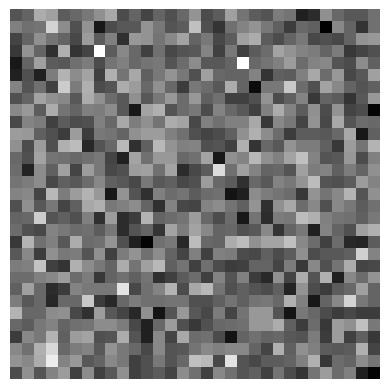

In [40]:
background = np.full((31,31), 100, dtype=np.float32)
background = np.random.poisson(background).astype(np.float32)
print(f"Mean: {np.mean(background)}, Std: {np.std(background)}, Max: {np.max(background)}, sqrt_mean: {np.sqrt(np.mean(background))}")
plt.imshow(background, cmap='gray')
plt.axis('off')
plt.show()

SNR is 10


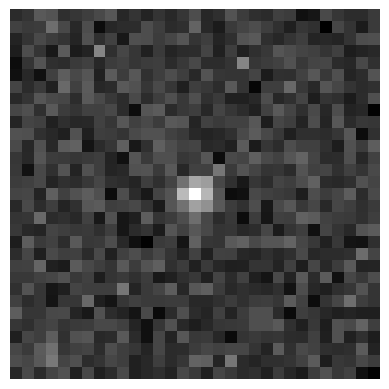

In [42]:
full_image = background.copy()
full_image[12:12+psf_1s_100int.shape[0], 12:12+psf_1s_100int.shape[1]] += psf_1s_100int
print("SNR is 10")
plt.imshow(full_image, cmap='gray')
plt.axis('off')
plt.show()

psf max: 30.0
SNR is 3


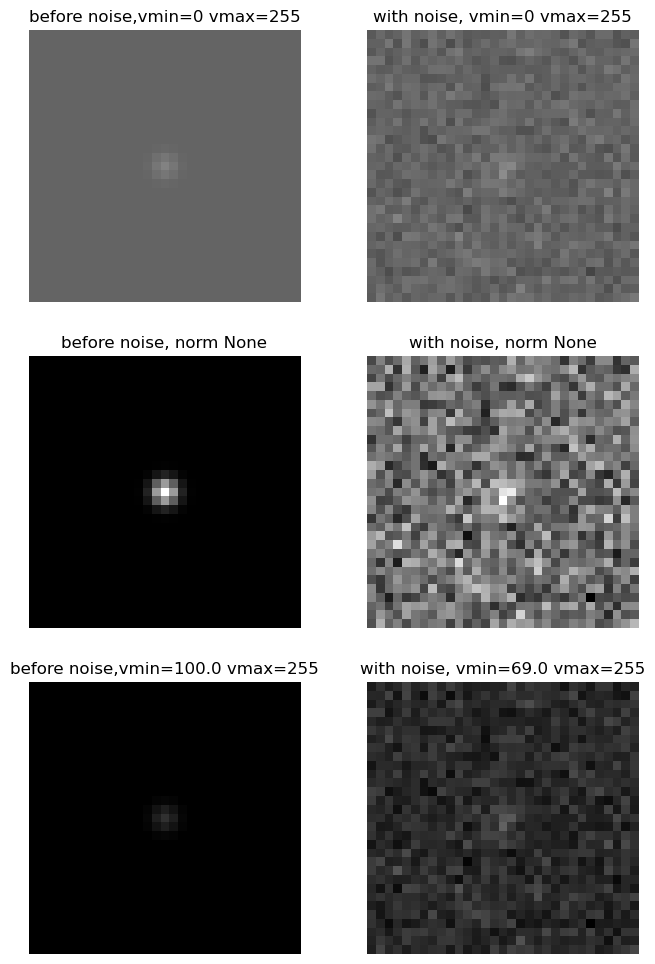

In [85]:
psf_1s_30int = make_psf(1, 30, (0.5,0.5)).astype(np.float32)
print(f"psf max: {np.max(psf_1s_30int)}")
background = np.full((31,31), 100, dtype=np.float32)
full_image = background.copy()
full_image[12:12+psf_1s_30int.shape[0], 12:12+psf_1s_30int.shape[1]] += psf_1s_30int

full_image_wnoise = full_image.copy()
full_image_wnoise = np.random.poisson(full_image_wnoise).astype(np.float32)

print("SNR is 3")

plt.figure(figsize=(8, 12))

plt.subplot(3,2,1)
plt.imshow(full_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title("before noise,vmin=0 vmax=255")

plt.subplot(3,2,2)
plt.imshow(full_image_wnoise, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title("with noise, vmin=0 vmax=255")

plt.subplot(3,2,3)
plt.imshow(full_image, cmap='gray', norm=None)
plt.axis('off')
plt.title("before noise, norm None")

plt.subplot(3,2,4)
plt.imshow(full_image_wnoise, cmap='gray', norm=None)
plt.axis('off')
plt.title("with noise, norm None")

plt.subplot(3,2,5)
plt.imshow(full_image, cmap='gray', vmin=np.min(full_image), vmax=255)
plt.axis('off')
plt.title(f"before noise,vmin={np.min(full_image)} vmax=255")

plt.subplot(3,2,6)
plt.imshow(full_image_wnoise, cmap='gray', vmin=np.min(full_image_wnoise), vmax=255)
plt.axis('off')
plt.title(f"with noise, vmin={np.min(full_image_wnoise)} vmax=255")

plt.tight_layout
plt.show()